In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

timestamps = pd.read_csv("./data.csv")
display(
    timestamps.groupby(["kex", "auth"]).size(
    ).reset_index(name="count").sort_values(["kex", "auth"])
)

,kex,auth,count
0,mlkem512,mldsa44-mldsa44-mldsa44,3192
1,mlkem512,sphincs128f-mldsa44-mldsa44,3317
2,secp256r1,rsa2048-rsa2048-rsa2048,3017
3,secp256r1,sha256ecdsa-sha256ecdsa-sha256ecdsa,3004
4,x25519,ed25519-ed25519-ed25519,3026


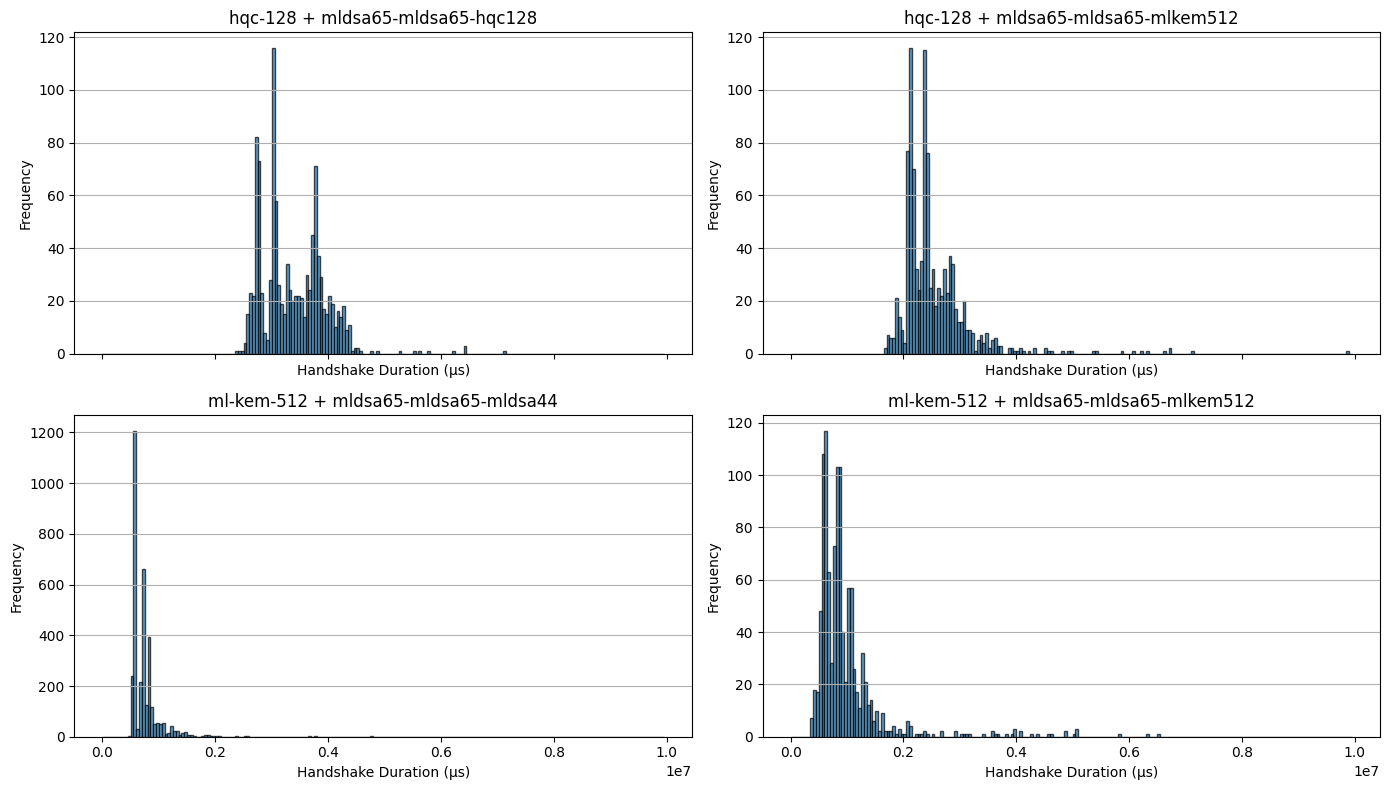

In [11]:
stats = timestamps.copy()
# compute durations and validate
stats["kex_dur"] = stats["sh_done"] - stats["ch_start"]
assert (stats["kex_dur"] > 0).all(), "non-positive key exchange duration"
stats["auth_dur"] = stats["auth_done"] - stats["auth_start"]
assert (stats["auth_dur"] > 0).all(), "non-positive authentication duration"
stats["hs_dur"] = stats["auth_done"] - stats["ch_start"]
assert (stats["hs_dur"] > 0).all(), "non-positive handshake duration"

def get_aggregate(stats: pd.DataFrame):
    # remove outliers based on handshake time
    trim_perc = 15  # remove top 10% and bottom 10%
    upper = stats["hs_dur"].quantile(1 - trim_perc / 100)
    lower = stats["hs_dur"].quantile(trim_perc / 100)
    stats = stats.loc[(stats["hs_dur"] <= upper) & (stats["hs_dur"] >= lower)]

    # compute statistic
    p90 = lambda x: np.percentile(x, 90)
    p99 = lambda x: np.percentile(x, 99)
    summary = stats.groupby(["kex", "auth"])[
        ["kex_dur", "auth_dur", "hs_dur"]
        ].agg(
            ["median", p90, p99, "std"]
        ).reset_index().rename(columns={
            "<lambda_0>": "P90", "<lambda_1>": "P99"
        }).round(2).sort_values(("hs_dur", "median"))  
    
    return summary

# display(get_aggregate(stats))

bins = [x for x in range(0, 10_000_000, 50000)]
stats["group"] = stats["kex"] + " + " + stats["auth"]

# Unique groups and layout
groups = stats["group"].sort_values().unique()
n_groups = len(groups)
n_cols = 2
n_rows = math.ceil(n_groups / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 4 * n_rows), sharex=True)
axes = axes.flatten()  # Flatten in case of single row

# Plot each group in its own subplot
for idx, group_label in enumerate(groups):
    ax = axes[idx]
    group_df = stats[stats["group"] == group_label]
    ax.hist(group_df["hs_dur"], bins=bins, edgecolor='black', alpha=0.7)
    ax.set_title(group_label)
    ax.set_xlabel("Handshake Duration (μs)")
    ax.set_ylabel("Frequency")
    ax.grid(axis='y')

# Hide unused subplots if any
for j in range(idx + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()